<h1>Sampling Experimentation</h1>

First, the packages needed for the experiment are imported and relevant measures such as bounds and error for correlation are set.

In [17]:
#import packages and define the model to sample from
from math import sqrt
import statistics
from collections import deque
from numpy.random import Generator, PCG64
import random
import numpy as np
from scipy import optimize
import matplotlib.pyplot as plt
font = {
        'weight' : 'bold',
        'size'   : 14}
plt.rc('font', **font)

# LPS: I've un-hardcoded the maximum distance at which we sample data. 
# LPS: I've now made the bounds a constant that you can change easily
LowerBound = 100
MaxDistance = 4000
e = 0.15 #error value
# LPS: I've un-hardcoded the true value as we might want to play with this later. 
ValueTRUE = 400
iterations = 100 #the maximum no. of iterations for each sample
UpperBound = MaxDistance#4000
reps = 1000 #how many times to repeat the whole experiment
rp0 = np.random.uniform(100,1000) #sample initial random guess of D-hat for curve fitting

<h2>Generating Noisy Artificial Data</h2>

In [18]:
#np.#random.seed(8)
dictsize = 100               

my_dict = {key: 0 for key in range(0, UpperBound+1)} #keep track of how many times a value was accessed; reset before each algorithm run

def getNoise(d):
    d = round(d) #round to the nearest integer
    count = my_dict[d]
    my_dict[d] += 1 #noise for d value accessed once; increment counter to get different noise
    if(my_dict[d] == dictsize):

        #print("dict limit reached for value: ",d)
        my_dict[d] = 0 #cycle back to avoid going out of bounds
    return error_arrays[count][d]

error_arrays = []
for i in range(0,dictsize):
    rng = Generator(PCG64(seed=i))
    error_array = rng.normal(loc = 0, scale = e, size = 4001) #normal dist. centred around 0 with st.dev. e 
    error_arrays.append(error_array)


#function to calculate correlation (rho) for distance to cell, d, and correlation distance, D
def cordist(d,D): 
    rho = 2**(-d/D)
    return(rho)

#generate correlation value using the function above, with corr. distance fixed  (D=400km). Distance to grid cell, d, is the input parameter. 
def generate_value(d,err): 
    rho = cordist(d,ValueTRUE) #We know that the true value of D is 400km
    noisyrho = rho + getNoise(d)  #add random error to rho, taken from a normal distribution with mean = 0 and standard deviation = e
    return(noisyrho) #returns the resulting noisy correlation value


    

<h2>Test Noise</h2>

In [19]:
my_dict = {key: 0 for key in range(0, UpperBound+1)}
print(getNoise(300))
print(getNoise(300))
print(getNoise(300))
my_dict = {key: 0 for key in range(0, UpperBound+1)}
print(getNoise(300))

0.18048884311747468
-0.08891617915712234
0.23742084180381995
0.18048884311747468


<h2>Random Point Generation</h2>

D-hat estimate:  [379.56366818]
covariance:  [[90.8439669]]
63.69616873214543
26.97867137638703


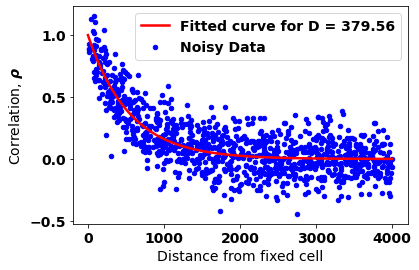

In [20]:

#np.#random.seed(8)
my_dict = {key: 0 for key in range(0, UpperBound+1)} #keep track of how many times a value was accessed
#a function that generates n random samples, with distance values of a given range
def generate_random_samples(n,lower_bound,upper_bound,err): 
    #rng = Generator(PCG64(seed=0))
    x = []
    y = []
    for i in range(n): 
        d= np.random.uniform(lower_bound,upper_bound) #generate random distance value from fixed cell as a sample from a uniform distribution, in the range L.B. to U.B.
        rho_noisy = generate_value(d,err)
        
        x.append(d)
        y.append(rho_noisy)
    return (x,y)

#Generate scatter plot of distance vs correlation, with random colors to help differentiate overlapping points. 
m = 1000 #number of samples
x,y = generate_random_samples(m,0,MaxDistance,e) #pass distance bounds and st. error
plt.figure(0)
plt.scatter(x,y, c='blue', s=20) 

plt.xlabel("Distance from fixed cell")
plt.ylabel(r'Correlation, $\rho$')
#plt.title("Scatter plot of generated distance and correlation values")

params, covs = optimize.curve_fit(cordist, xdata = x, ydata = y, p0=rp0) #fit curve with generated data and initial guess for parameter as 400km

print("D-hat estimate: ", params) #this prints the value of b (corr. distance) estimated from the curve fit on the generated data
print("covariance: ", covs)

#Plot the fitted curve by calculating y values based on rho without noise
axis_d = np.array(range(MaxDistance)) #prepare the axis for the fitted line
yfit = 2**(-axis_d/params[0]) #use the estimated D-hat for the fitted line
plt.plot(axis_d, yfit, c='red',linewidth='2.5')
l_strg = "Fitted curve for " + "D" + " = " + str(round(params[0],2))
plt.legend((l_strg,'Noisy Data'))

rng = Generator(PCG64(seed=0))
print(rng.uniform(low=0,high=100,size=1)[0])
print(rng.uniform(low=0,high=100,size=1)[0])



<h2>Uncertainty Sampling</h2>

In [21]:
#np.#random.seed(8)
def samplechoice(lb,ub,numpoints):#calculate points and randomness range
    
    step = (ub - lb) / numpoints

    pts = [(lb+i*step) for i in range(0,numpoints)]
    randrange = (ub-lb)/(numpoints) 

    return(pts,randrange)
#Holds list of values for each repetition
Dhat_arr_lst = [  ]
cov_arr_lst = [  ]
x_lst = [  ]
y_lst = [  ]
diffat100 = []

my_dict = {key: 0 for key in range(0, UpperBound+1)}
negcount = 0

for r in range(0,reps):
    my_dict = {key: 0 for key in range(0, UpperBound+1)}
    error_arrays = []
    rng = Generator(PCG64(seed=r))
    rp0 = rng.uniform(100, 1000) #sample initial random guess of D-hat for curve fitting

    for i in range(0,dictsize):
        
        #error_array = np.random.normal(0, e, size=4001) 
        error_array = rng.normal(loc = 0, scale = e, size = 4001) #normal dist. centred around 0 with st.dev. e 
        error_arrays.append(error_array)


    Dhat_arr = []
    cov_arr = []

    p_low = generate_value(LowerBound,e) #generate values for rho for distances 100km and 1000km using the neg. exp. model (again, with noise)
    p_upper = generate_value(UpperBound,e)

    x = [LowerBound,UpperBound]
    y = [p_low,p_upper] #store distance and rho values in lists for easy plotting

    q2 = (LowerBound+UpperBound)/2
    rhoq2 = generate_value(q2,e)

    x.append(q2)
    y.append(rhoq2)

    params, covs = optimize.curve_fit(cordist, xdata = x, ydata = y, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates


    Dhat_arr.append(params[0]) #new estimate of correlation distance, D-hat
    cov_arr.append(sqrt(covs[0][0]))
    #print("x size before iteratiing:",len(x))
    i_arr = [0]  #used as x axis to plot iteration number. the loop will start from iteration no. 1(not 0) and the list will be updated each time.
    


    for i in range(0,iterations):
        i_arr.append(i+1) #update every iteration


        if(len(x)<25): #switching criteria based on size of cluster
            sf = 1.5
            for j in range(0,4):
                
                #print("scalefactor",sf)
                b =  Dhat_arr[i-1] + sf * cov_arr[i-1] #the two interval bounds
                a =  Dhat_arr[i-1] - sf * cov_arr[i-1]

                #if a is negative, take 4 random points and move to next iteration of loop to prevent NaN error
                if a < 0: 
                    negcount+=1
                    #print("negative a on j ->",j,"count:",negcount)
                    for k in range(0,4-j): #only take as many random points as needed
                        d = np.random.uniform(LowerBound,UpperBound)
                        rhod = generate_value(d,e)
                        x.append(d)
                        y.append(rhod)
                    break
                    
                d = - (a*b*np.log(a/b)) / (np.log(2)*(b-a)) #get the max. distance between the curves; natural log by default for numpy
                rhod = generate_value(d,e)
                x.append(d)
                y.append(rhod)
                sf+=0.5
                
        else: #if 25 samples have been taken, do random sampling
            pts, randrange = samplechoice(LowerBound,MaxDistance,4) #generate 4 equidistant points with some noise range for randomness
            for j in pts:
                d = j + np.random.uniform(-1*randrange,randrange) #add some noise to ensure different distances are sampled each time
                while(d > MaxDistance or d < LowerBound): #if distance is outside bounds, resample
                    d = j + np.random.uniform(-1*randrange,randrange)

                rho = generate_value(d,e)
                x.append(d)
                y.append(rho)

        
        params, covs = optimize.curve_fit(cordist, xdata = x, ydata = y, p0=rp0) #fit the curve onto the 2 data points and get D-hat and covariance estimates
        Dhat_arr.append(params[0]) #new estimate of correlation distance, D-hat
        cov_arr.append(sqrt(covs[0][0]))
        if(i == iterations-1):
            diff = params[0] - ValueTRUE
            diffat100.append(diff)

    
    Dhat_arr_lst.append(Dhat_arr)
    cov_arr_lst.append(cov_arr)
    x_lst.append(x)
    y_lst.append(y)





<ipython-input-18-b55404d25865>:25: RuntimeWarning: overflow encountered in power
  rho = 2**(-d/D)


<h2>Plotting</h2>

error value: 0.15


(0.0, 1000.0)

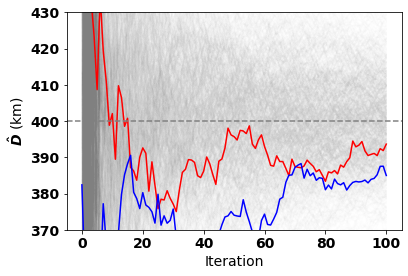

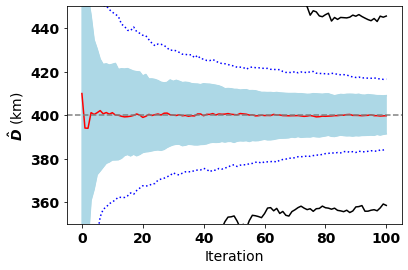

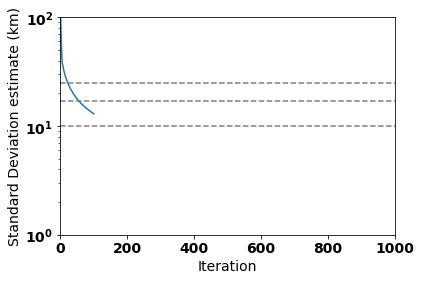

In [22]:
#print("p0 value:",rp0)
print("error value:",e)

folder = "plots"

def absdiff(i):
    return (i-ValueTRUE)


plt.figure(8)
for i in range(0,len(Dhat_arr_lst)):
    if (i == len(Dhat_arr_lst)-1):
        plt.plot(i_arr,Dhat_arr_lst[0], label = 'V2',color='red') 
        plt.plot(i_arr,Dhat_arr_lst[i], label = 'V2',color='blue') 
    else:
        plt.plot(i_arr,Dhat_arr_lst[i], label = 'V2',alpha=0.01,color='gray') #v2  
plt.axhline(y=ValueTRUE, color='gray', linestyle='--')
plt.ylim([370,430])
plt.ylabel('$\hat{D}$ (km)')
plt.xlabel('Iteration')  

Dhat_min = []
Dhat_max = []
Dhat_med = []
Dhat_q1 = []
Dhat_q3 = []
Dhat_10 = []
Dhat_90 = []
std_med = []

for i, items in enumerate(zip(*Dhat_arr_lst)):
    # Find min, max, and median for each iteration
    minv = min(items)
    maxv = max(items)
    quartiles = statistics.quantiles(items) #gets the 3 quartiles
    percentile_10 = statistics.quantiles(items, n=10)[0]
    percentile_90 = statistics.quantiles(items, n=10)[-1]
    Dhat_min.append(minv)
    Dhat_max.append(maxv)
    Dhat_q1.append(quartiles[0])
    Dhat_q3.append(quartiles[2])
    Dhat_med.append(quartiles[1])
    Dhat_10.append(percentile_10)
    Dhat_90.append(percentile_90)

for j, items in enumerate(zip(*cov_arr_lst)):
    median = statistics.median(items)
    std_med.append(median)
    

plt.figure(77)
plt.plot(i_arr,Dhat_min, c='black')
plt.plot(i_arr,Dhat_max, c='black')

plt.plot(i_arr,Dhat_q1, color='lightblue')
plt.plot(i_arr,Dhat_med,color = 'red')
plt.plot(i_arr,Dhat_q3, color='lightblue')
plt.plot(i_arr,Dhat_10, color='blue',linestyle = 'dotted')
plt.plot(i_arr,Dhat_90, color='blue',linestyle = 'dotted')

plt.fill_between(i_arr, Dhat_q1, Dhat_q3, color='lightblue')

plt.ylim([350,450])
plt.ylabel('$\hat{D}$ (km)')
plt.xlabel('Iteration') 
plt.axhline(y=(ValueTRUE), color='gray', linestyle='--')
#plt.legend(loc="upper right")


#Plot median of st. dev. at each iteration
plt.figure(60)
plt.plot(i_arr,std_med, label = 'V2')
plt.axhline(y=(10), color='gray', linestyle='--')
plt.axhline(y=(25), color='gray', linestyle='--')
plt.axhline(y=(17), color='gray', linestyle='--')

plt.yscale('log')
plt.ylim([1,10**2])
plt.ylabel('Standard Deviation estimate (km)') # LPS: As there is only one variable, this is the variance of this variable. 
plt.xlabel('Iteration')  
plt.xlim(0,1000)




total no. of samples for USR 403


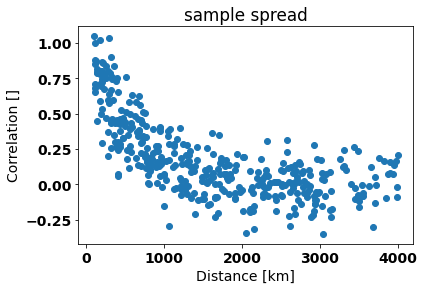

In [23]:


#I made one for V2 as well
plt.figure(7)
plt.title("sample spread")
plt.scatter(x,y)
#plt.plot(np.arange(4000), cordist(np.arange(4000), *params), 'g--',label='fitted function')
plt.ylabel('Correlation []') 
plt.xlabel('Distance [km]')  


print("total no. of samples for USR",len(x))

action point: define a grid with 1 dec place (for noise), 2 grid versions (one with while loop and another with error dampening), implement same sampling methods on the grid, then run each algorithm 1000x and take mean of the samples, plot with error graphs to gauge spread.

In [28]:
import pickle
import os

folder_path = "results_U5100iters"
folder_path = folder_path + "_" + (str(e)).replace('.','_') + '__' + str(reps) #make separate folders based on noise value of synthetic data

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

file_path = os.path.join(folder_path, "i_arr.pkl")
with open(file_path, 'wb') as f:
    pickle.dump(i_arr, f)

file_path = os.path.join(folder_path, "Dhat_med.pkl")
with open(file_path, 'wb') as f:
    pickle.dump(Dhat_med, f)

file_path = os.path.join(folder_path, "Dhat_10.pkl")
with open(file_path, 'wb') as f:
    pickle.dump(Dhat_10, f)

file_path = os.path.join(folder_path, "Dhat_90.pkl")
with open(file_path, 'wb') as f:
    pickle.dump(Dhat_90, f)

file_path = os.path.join(folder_path, "Dhat_min.pkl")
with open(file_path, 'wb') as f:
    pickle.dump(Dhat_min, f)

file_path = os.path.join(folder_path, "Dhat_max.pkl")
with open(file_path, 'wb') as f:
    pickle.dump(Dhat_max, f)

file_path = os.path.join(folder_path, "Dhat_q1.pkl")
with open(file_path, 'wb') as f:
    pickle.dump(Dhat_q1, f)

file_path = os.path.join(folder_path, "Dhat_q3.pkl")
with open(file_path, 'wb') as f:
    pickle.dump(Dhat_q3, f)

file_path = os.path.join(folder_path, "std_med.pkl")
with open(file_path, 'wb') as f:
    pickle.dump(std_med, f)

file_path = os.path.join(folder_path, "Dhat_lists.pkl")
with open(file_path, 'wb') as f:
    pickle.dump(Dhat_arr_lst, f)

file_path = os.path.join(folder_path, "diffat100.pkl")
with open(file_path, 'wb') as f:
    pickle.dump(diffat100, f)

12.848722932837568


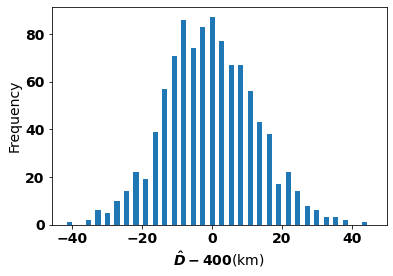

In [27]:
plt.figure(23)
indices = list(range(len(diffat100)))

plt.hist(diffat100, bins=round(np.sqrt(len(diffat100))), width = 1.5)
plt.xlabel('$\hat{D}-400$(km)')
plt.ylabel('Frequency')
std = np.std(diffat100)
print(std)
name = 'plots/Hist100_U5' + (str(std)).replace('.','_') + ('.pdf')
plt.savefig(name)
#plt.text(0.05, -0.15, f"Standard deviation: {std:.2f}", transform=plt.gca().transAxes)
#fit normal curve to the data and figure out the standard deviation of this list.
